In [1]:
import torch

# 日期：20210912

In [2]:
# 调试代码问题分析
# 输出的维度为 [16, 1]；label的维度为[16]
# UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
# 已经提示过我警告了，我却忽视了这个问题，导致我最后无论如何都不能得到正确的训练结果。我的任务在做拟合，输出的是1维向量，由于维度
# 不一致，导致我的loss计算错误，因此无法收敛。

# 0.8595125089639238 0.23874292

# 关于计算loss前的系数，同样的epoch，将label放大1000倍，效果更好。
# 剩下的慢慢调参

# batch_size ；epoch的数目为50；cutoff=20A; num_gaussians=50
8  |  0.8183579705912989 0.2523386 
16 |  0.8509288759910987 0.25157732
32 |  0.5917329517746134 0.45238832
64 |  0.06652811486969124 0.64593333

# loss为L1Loss

# batch_size=16.; epoch的数目为50; num_gaussians=50; cutoff更改；
10A  | 0.6476927005873894 0.35879278
30A. | 0.7474838856036156 0.32469627
40A. | 0.883748432105143 0.21945754
50A  | 0.8030923758165811 0.28142178

# batch_size=16; epoch=50; cutoff=40; num_gaussians更改
80  ｜ 0.7790561828132698 0.29944378
100 ｜ 0.8666424459070403 0.23189509
150 ｜ 0.779505022598226 0.29540038
200 ｜ 0.6763320050195348 0.4067232

# batch_size=16; epoch=50; cutoff=40; num_gaussians=50; hidden_channels=128
num_interactions = 3 | 0.759200845539894 0.34300148
6 | 0.8947926696100269 0.21198566
9 | 0.6053692212407462 0.450316041
12 | 0.6254019412304221 0.4175421

# batch_size=16; epoch=50; cutoff=40; num_gaussians=50; hidden_channels改变
64  | 0.8026421528787104 0.31651202
128 | 0.8947926696100269 0.21198566
256 | 0.36406943300154715 0.5407379
512 | 0.8214548567039157 0.2687102



SyntaxError: invalid syntax (<ipython-input-2-25592ca13703>, line 13)

In [ ]:
# 20210913代码调试分析
# batch_size=16; epoch=50; cutoff=40; num_interactiΩns=6; num_gaussians=50; hidden_channels=128; num_filters改变
128 | 0.5443827101103578 0.45469874
256 |

# 同样的参数，hidden_channels=128, num_filters=128,
# num_interactions=6, num_gaussians=50, cutoff=40.0在50个epoch下训练，却出现了很大的误差。增大epoch后，误差变小
100 epochs| 0.8955096004156535 0.2113476
200 epochs| 0.9235541468698287 0.17481215


# 改变loss，重新训练；loss考虑结构原子的数目。
Cost = p*1/N * \sum_i((E_DFT-E_NN)/natoms)^2

100 epochs | 0.9422467573904357 0.13392238
200 epochs | 0.9107050562237629 0.19926395

# 100个epoch后差不多收敛了，后期需要使用summarywriter，检查平均误差随着epoch的增加的变化情况。

# 基于100个epoch和新的loss下，更改loss公式中的系数，检查训练情况。

# 系数p更改. 
10 
50  | 0.9422467573904357 0.13392238 
100 | 0.7652122355751045 0.27026865
200 | 0.6866290830493523 0.31898296

In [1]:
import pandas as pd
import numpy as np

In [9]:
in_file  = './HEA_Data/Out_labels/Binary.xlsx'
wb = pd.read_excel(io=in_file, sheet_name=0,engine='openpyxl', index_col=0)
a = wb.to_numpy()

In [55]:
a

array([['NiFe3_sqsfcc', -7.53137375, -120.50198, -0.10195, 0.0136,
        207.968, 2.105, 33.686, 0.4047, 11.57],
       ['NiFe_sqsfcc', -6.86894625, -109.90314, -0.09319, -0.01616,
        156.146, 1.601, 25.61, 0.0476, 11.33],
       ['Ni3Fe_sqsfcc', -6.19720531, -99.155285, -0.07512, -0.0366,
        108.959, 1.131, 18.093, 0.0251, 11.09],
       ['NiCo3_sqsfcc', -6.63636313, -106.18181, -0.00591, 0.00768,
        131.868, 1.39, 22.234, 0.0007, 10.84],
       ['NiCo_sqsfcc', -6.25139938, -100.02239, -0.00829, 0.00077,
        108.656, 1.144, 18.302, 0.0129, 10.85],
       ['Ni3Co_sqsfcc', -5.86477631, -93.836421, -0.00901, -0.00448,
        84.752, 0.891, 14.261, 0.0141, 10.85],
       ['NiMn3_sqsfcc', -8.028105, -128.44968, 0.0236, 0.07782, 16.546,
        0.165, 2.648, 0.0593, 11.03],
       ['NiMn_sqsfcc', -7.25307, -116.04912, -0.06246, -0.02631, 8.058,
        0.082, 1.311, 0.0846, 11.57],
       ['Ni3Mn_sqsfcc', -6.36271438, -101.80343, -0.0332, -0.01513,
        123.896, 1.2

In [63]:
np.random.seed(30)
b=np.random.permutation(a)

In [57]:
import os

In [78]:
class DataSegment:
    def __init__(self, base_dir):
        # For example, the base_dir is '../HEA_Data/Out_labels'.
        self.base_dir = base_dir

    def segment(self, types):
        """
        Utilize the low-component data to predict the high-component data.

        :param types: str.
        :return:
        """

        if types == 0:
            # binary + ternary
            in_file_list = ['Binary.xlsx', 'Ternary.xlsx']
            in_file_path = self.base_dir
            out_file = os.path.join(self.base_dir, 'B+T.xlsx')
        elif types == 1:
            # binary + ternary + quartenary
            in_file_list = ['Binary.xlsx', 'Ternary.xlsx', 'Quaternary.xlsx']
            in_file_path = self.base_dir
            out_file = os.path.join(self.base_dir, 'B+T+Qua.xlsx')
        elif types == 2:
            # quartenary + quinary
            in_file_list = ['Quaternary.xlsx', 'Quinary.xlsx']
            in_file_path = self.base_dir
            out_file = os.path.join(self.base_dir, 'Qua+Qui.xlsx')
        else:
            print('Not implemented!')
            return 0

        out = []
        for name in in_file_list:
            in_fie = os.path.join(in_file_path, name)
            a = self._read_excel(in_file=in_fie)
            out.append(a)
        out = np.vstack(out)
        df = pd.DataFrame(out)
        col_names = ['structures', 'Etot (eV/atom)', 'Etot (eV)', 'Emix (eV/atom)', 'Eform (eV/atom)',
                     'Ms (emu/g)', 'Ms (mub/atom)', 'mb (mub/cell)', 'rmsd (\\AA)', 'V0 (A3/atom)']
        df.columns = col_names
        df.describe()
        if out_file:
            df.to_excel(excel_writer=out_file)
        return df.values

    def train_test_split(self, train_ratio=0.8):
        """
        Split the whole dataset into the training data and testing data. The train_ratio controls
        the portion of the train data.

        :param types: float.
        :return:
        """

        filename = 'Database.xlsx'
        seed_nums = 30
        save_data = True
        in_file = os.path.join(self.base_dir, filename)
        a = self._read_excel(in_file=in_file)
        length = a.shape[0]
        train_nums = int(np.ceil(length* train_ratio))
        np.random.seed(seed_nums)
        random_a = np.random.permutation(a)
        train_data = random_a[:train_nums, :]
        test_data = random_a[train_nums:,:]
        if save_data:
            col_names = ['structures', 'Etot (eV/atom)', 'Etot (eV)', 'Emix (eV/atom)', 'Eform (eV/atom)',
                     'Ms (emu/g)', 'Ms (mub/atom)', 'mb (mub/cell)', 'rmsd (\\AA)', 'V0 (A3/atom)']

            df_train = pd.DataFrame(train_data)
            df_test = pd.DataFrame(test_data)

            df_train.columns = col_names
            df_test.columns = col_names

            df_train.to_excel(excel_writer=os.path.join(self.base_dir, 'train.xlsx'))
            df_test.to_excel(excel_writer=os.path.join(self.base_dir, 'test.xlsx'))
        return train_data, test_data

    def describe(self, filename):
        """
        Generate descriptive statistics.

        Descriptive statistics include shape of dataset.

        :param filename: str
        :return:
        """
        filename = os.path.join(self.base_dir, filename)
        a = self._read_excel(in_file=filename)
        rows, cols = a.shape
        print('Numbers of data: {}, properties:{}'.format(rows, cols - 1))
        return rows

    def _read_excel(self, in_file):
        """
        Read the excel file using the Pandas.
        :param in_file: str, the path name of the input file, such as '../HEA_Data/Quinary.xlsx'
        :return: ndarray.
        """
        wb = pd.read_excel(io=in_file, sheet_name=0, engine='openpyxl', index_col=0)
        array = wb.to_numpy()
        return array

In [79]:
ds = DataSegment(base_dir='./HEA_Data/Out_labels')

In [80]:
ds.describe('Binary.xlsx')
ds.describe('Ternary.xlsx')
ds.describe('Quaternary.xlsx')
ds.describe('Quinary.xlsx')
ds.describe('Database.xlsx')

Numbers of data: 84, properties:9
Numbers of data: 128, properties:9
Numbers of data: 97, properties:9
Numbers of data: 55, properties:9
Numbers of data: 364, properties:9


364

In [81]:
ds.segment(types=2)

array([['FeNiCoCr_sqsfcc', -7.48919, -479.30789, ..., 43.66, 0.0492,
        11.08],
       ['FeNiCoMn_sqsfcc', -7.38792, -472.8266, ..., 82.19, 0.0746,
        11.26],
       ['FeCoCrMn_sqsfcc', -8.33881, -533.68358, ..., 25.5, 0.0559,
        10.93],
       ...,
       ['Fe24Ni64Co24Cr24Pd24_sqsbcc', -6.6385, -1062.1596, ..., 115.63,
        0.8157, 11.87],
       ['Fe24Ni24Co64Cr24Pd24_sqsbcc', -7.00565, -1120.9047, ..., 131.45,
        1.1071, 11.84],
       ['Fe24Ni24Co24Cr64Pd24_sqsbcc', -7.57075, -1211.3201, ..., 38.98,
        0.6252, 11.91]], dtype=object)

In [83]:
ds.train_test_split()

(array([['CrCoPd_sqsbcc', -7.1049325, -255.77757, ..., 17.31, 0.73254,
         12.76],
        ['Fe2CrCo_sqsfcc', -8.149505, -260.78415, ..., 27.73, 0.0495,
         11.053],
        ['NiCrPd2_sqsfcc', -6.319172, -202.2135, ..., 15.5, 0.093, 13.65],
        ...,
        ['Fe12Ni28Co12Pd12_sqsbcc', -6.23165, -398.8254, ..., 75.56,
         0.7536, 11.98],
        ['Fe12Ni12Cr28Mn12_sqsbcc', -8.31111, -531.91128, ..., 33.47,
         0.0905, 11.31],
        ['Fe19Ni15Co15Pd15_sqsfcc', -6.58835, -421.65414, ..., 92.55,
         0.0845, 12.31]], dtype=object),
 array([['NiCoMn2_sqsfcc', -7.560907, -241.94901, 0.01705, 0.05773, 65.34,
         0.665, 21.29, 0.0643, 11.09],
        ['NiCo3_sqsbcc', -6.548455, -104.77528, -0.00257, 0.09559,
         136.776, 1.441, 23.062, 0.2511, 11.04],
        ['NiCr3_sqsfcc', -8.38084813, -134.09357, -0.17558, 0.11749,
         4.763, 0.046, 0.732, 0.3989, 11.41],
        ['FeCr_sqsbcc', -8.79082125, -140.65314, 0.08191, 0.08191, 99.189,
         0.983, 

In [85]:
ds.describe('train.xlsx')
ds.describe('test.xlsx')

Numbers of data: 292, properties:9
Numbers of data: 72, properties:9


72

In [2]:
# check the performance.

from utils.registry import registry, setup_imports

setup_imports()

model = registry.get_model('heanet'
                           )(hidden_channels=128,
                             num_filters=128,
                             num_interactions=6,
                             num_gaussians=50,
                             cutoff=10,
                             readout='add',
                             dipole=False, mean=None, std=None,
                             atomref=None)

In [4]:
for param in model.named_parameters():
    print(param[0], param[1].size())

embedding.weight torch.Size([100, 128])
interactions.0.mlp.0.weight torch.Size([128, 50])
interactions.0.mlp.0.bias torch.Size([128])
interactions.0.mlp.2.weight torch.Size([128, 128])
interactions.0.mlp.2.bias torch.Size([128])
interactions.0.conv.lin1.weight torch.Size([128, 128])
interactions.0.conv.lin2.weight torch.Size([128, 128])
interactions.0.conv.lin2.bias torch.Size([128])
interactions.0.lin.weight torch.Size([128, 128])
interactions.0.lin.bias torch.Size([128])
interactions.1.mlp.0.weight torch.Size([128, 50])
interactions.1.mlp.0.bias torch.Size([128])
interactions.1.mlp.2.weight torch.Size([128, 128])
interactions.1.mlp.2.bias torch.Size([128])
interactions.1.conv.lin1.weight torch.Size([128, 128])
interactions.1.conv.lin2.weight torch.Size([128, 128])
interactions.1.conv.lin2.bias torch.Size([128])
interactions.1.lin.weight torch.Size([128, 128])
interactions.1.lin.bias torch.Size([128])
interactions.2.mlp.0.weight torch.Size([128, 50])
interactions.2.mlp.0.bias torch.Si

In [31]:
model.interactions

ModuleList(
  (0): InteractionBlock(
    (mlp): Sequential(
      (0): Linear(in_features=50, out_features=128, bias=True)
      (1): ShiftedSoftplus()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (conv): CFConv(
      (lin1): Linear(in_features=128, out_features=128, bias=False)
      (lin2): Linear(in_features=128, out_features=128, bias=True)
      (nn): Sequential(
        (0): Linear(in_features=50, out_features=128, bias=True)
        (1): ShiftedSoftplus()
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (act): ShiftedSoftplus()
    (lin): Linear(in_features=128, out_features=128, bias=True)
  )
  (1): InteractionBlock(
    (mlp): Sequential(
      (0): Linear(in_features=50, out_features=128, bias=True)
      (1): ShiftedSoftplus()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (conv): CFConv(
      (lin1): Linear(in_features=128, out_features=128, bias=False)
      (lin2): Linear(in_feat

In [1]:
# for i in model.modules():
#     print(i)
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [6]:
import torch
from datasets.preprocessing import PoscarToGraph
from datasets.HEA_dataset import HEADataset
from torch_geometric.data import DataLoader

#-----------------Method1----------------------------#
pg = PoscarToGraph(radius=6, max_neigh=200)
data = pg.to_graph('./HEA_Data/Binary_POSCAR_Files/POSCAR_Co3Cr_sqsbcc')
# edge_index = data.edge_index
# positions = data.pos
# # print(positions)
print(data.atomic_numbers)
print(data)
# print()
# print(torch.max(edge_index[0, :]), torch.max(edge_index[1, :]))
# # print(edge_index[:,200:])
# print(data)

#--------------------Method2---------------------------#
# dataset = HEADataset(poscar_dir='./HEA_Data/POSCARS', label_name='./HEA_Data/Out_labels/Database.xlsx', task='etot')

# train_loader = DataLoader(dataset=dataset, batch_size=2)
# print(train_loader.dataset[0])
# for i, b in enumerate(train_loader):
#     print(b)
#     print(b.etot)
#     print(b.num_atoms)

tensor([27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 24., 24.,
        24., 24.])
Data(atomic_numbers=[16], cell=[1, 3, 3], cell_offsets=[1170, 3], edge_distances=[1170], edge_index=[2, 1170], neighbors=1170, num_atoms=16, pos=[16, 3])


/Users/xinming/PycharmProjects/HEA_project/datasets/preprocessing.py:337: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370253951/work/torch/csrc/utils/tensor_numpy.cpp:141.)



In [7]:
# x=train_loader.dataset[0]
x = data
x

Data(atomic_numbers=[16], cell=[1, 3, 3], cell_offsets=[1170, 3], edge_distances=[1170], edge_index=[2, 1170], neighbors=1170, num_atoms=16, pos=[16, 3])

In [33]:
# for i in model.modules():
#     print(i)
activation = {}
def get_activation(name):
    def hook(model, input, output):
#         print(output.detach().size())
        activation[name] = output.detach()
    return hook

In [56]:
model.interactions[0].lin.register_forward_hook(get_activation('interactions1'))
model.interactions[2].lin.register_forward_hook(get_activation('interactions3'))
model.interactions[5].lin.register_forward_hook(get_activation('interactions6'))
output = model(x.atomic_numbers.long(), x.pos)
# print(activation)

In [10]:
feature = activation['interactions5']
feature.size()

torch.Size([2, 128])

In [13]:
feature.numpy().shape

(2, 128)

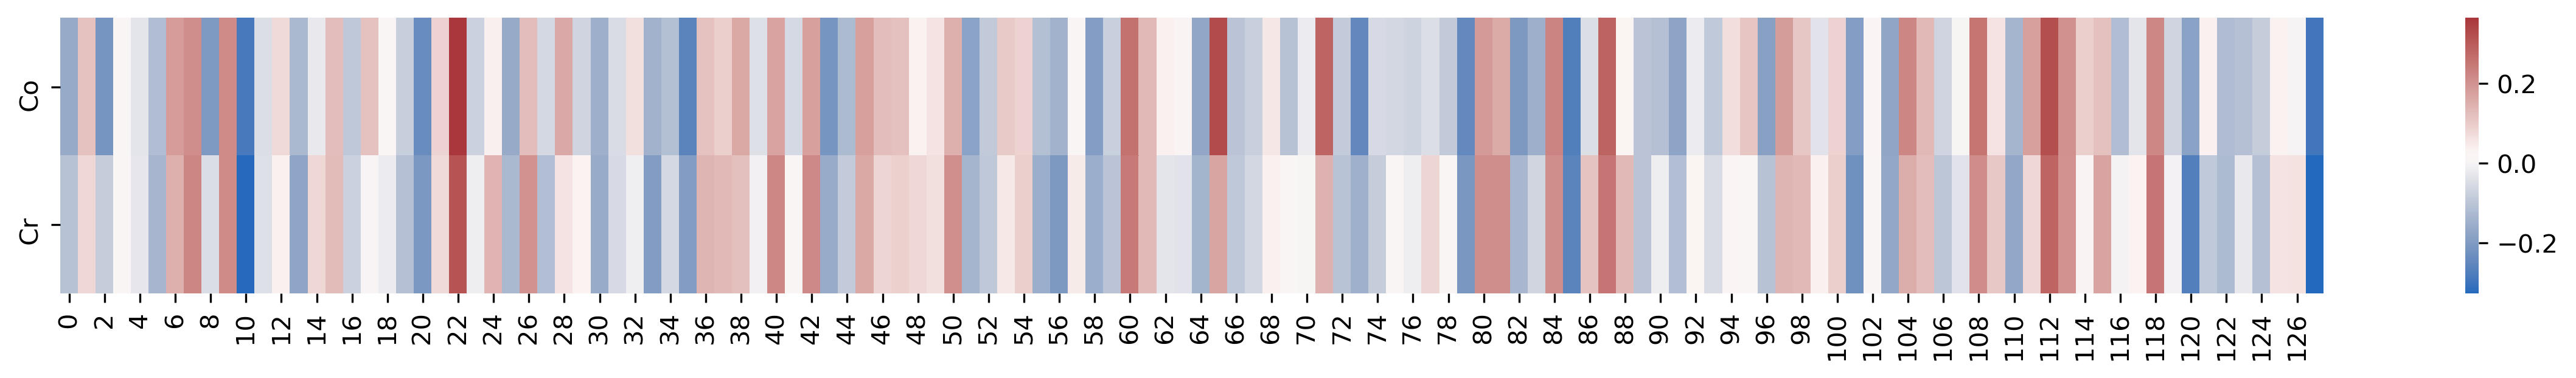

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
# Plot a heatmap for a numpy array:
# uniform_data = np.random.rand(12,10)

fig = plt.figure(figsize=(20, 2),dpi=300)
# x_axis_labels = [1,2,3,4,5,6,7,8,9,10,11,12] # labels for x-axis
y_axis_labels = ['Co', 'Cr'] # labels for y-axis
# cmap='Blues', 'YlGnBu', 'vlag'

# [left, bottom, width, height] 
# cbar_ax = fig.add_axes([0.7, 0, 0.025, 0.2])

ax = sns.heatmap(feature.numpy(), cmap='vlag', yticklabels=y_axis_labels)



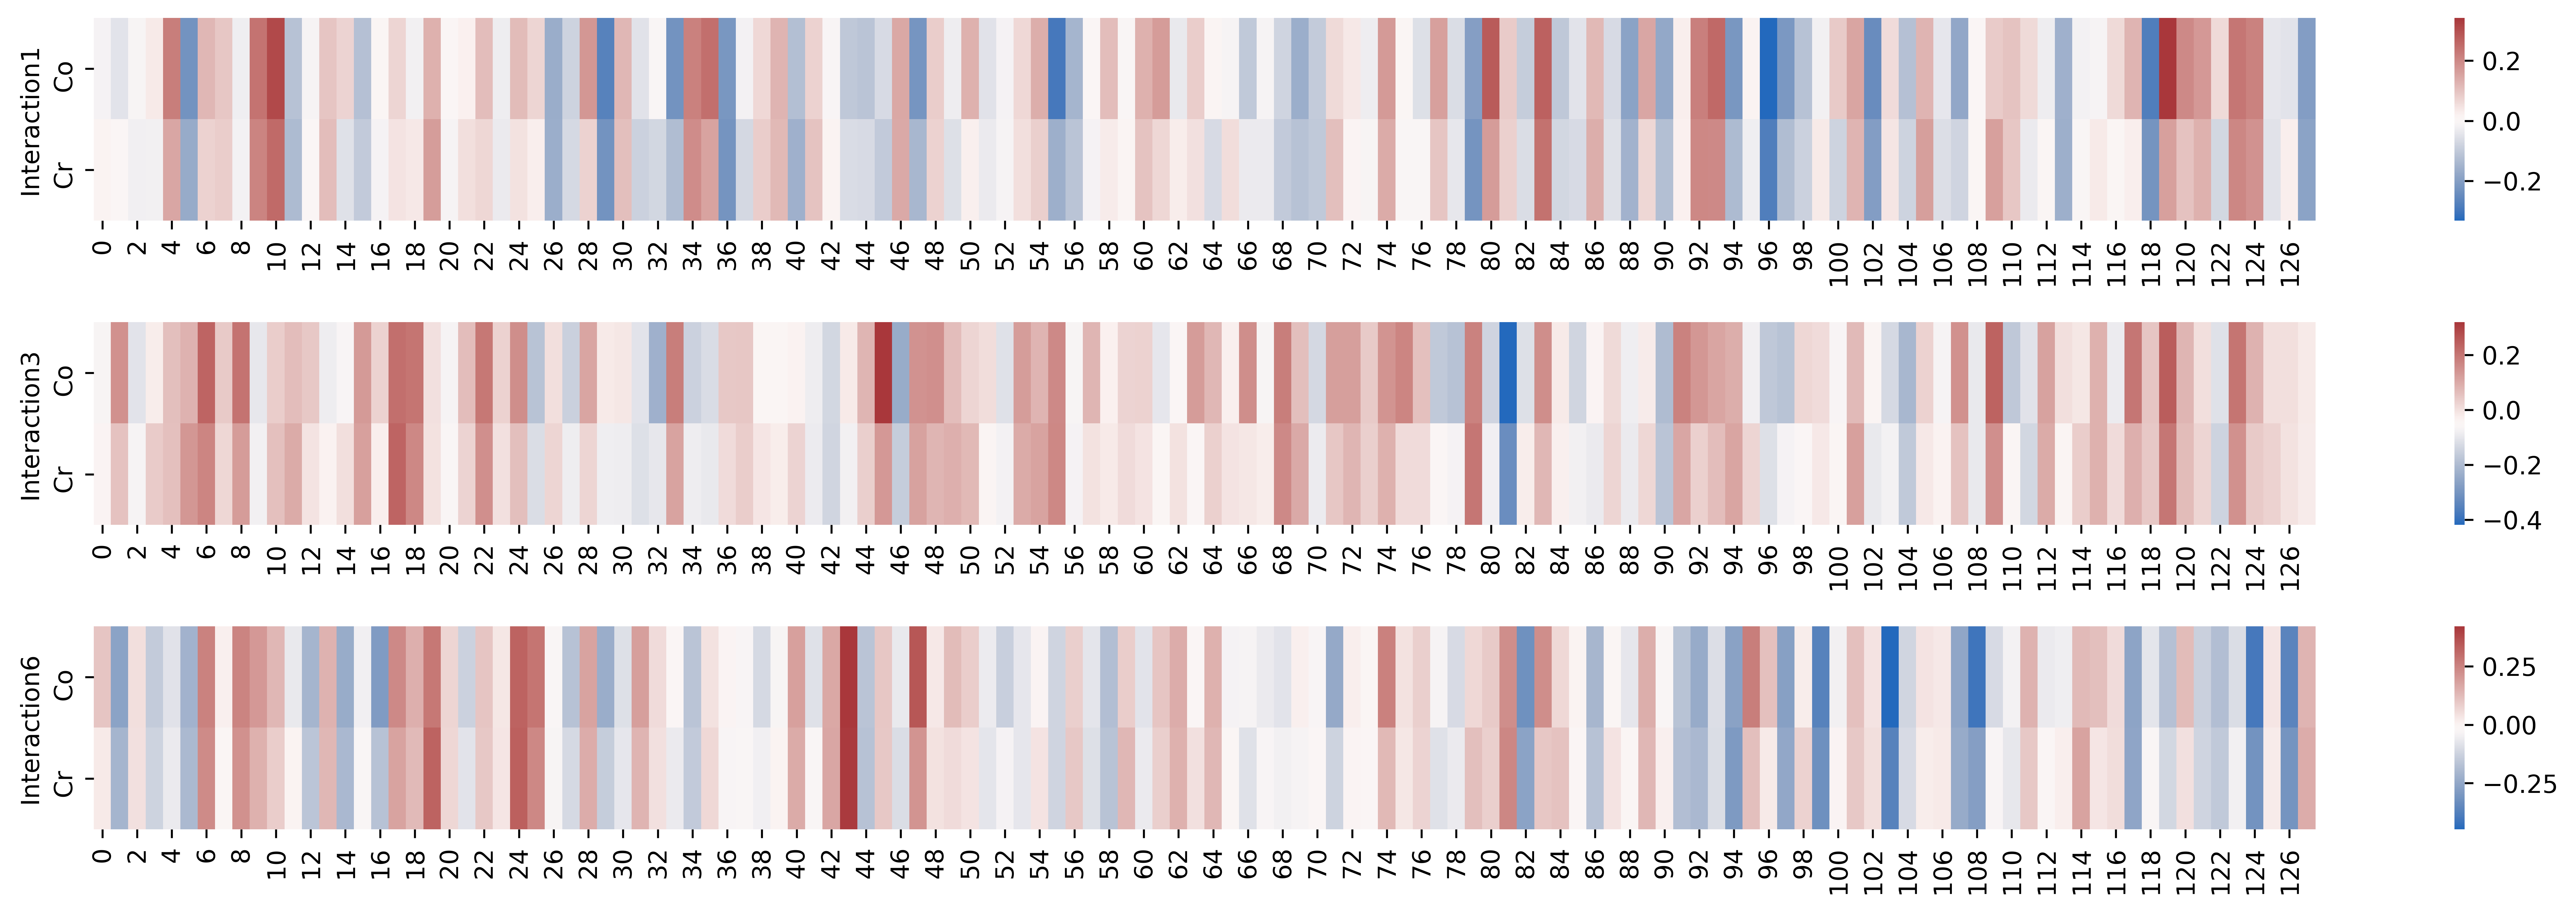

In [57]:
fig_path = '/Users/xinming/Documents/work/高熵合金/figures'
import os
feature1 = activation['interactions1']
feature3 = activation['interactions3']
feature6 = activation['interactions6']
# fig = plt.figure(figsize=(20, 8),dpi=300)
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(20,6 ), dpi=600)

ax1 = plt.subplot(3,1,1)
ax = sns.heatmap(feature1.numpy(), cmap='vlag', yticklabels=y_axis_labels, ax=ax1)
ax1.set_ylabel('Interaction1')

ax2 = plt.subplot(3,1,2)
ax = sns.heatmap(feature3.numpy(), cmap='vlag', yticklabels=y_axis_labels, ax=ax2)
ax2.set_ylabel('Interaction3')

ax3 = plt.subplot(3,1,3)
ax = sns.heatmap(feature6.numpy(), cmap='vlag', yticklabels=y_axis_labels, ax=ax3)
ax3.set_ylabel('Interaction6')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.savefig(os.path.join(fig_path,'features_co3cr_bcc.jpg'))

In [25]:
#-----------------Method1----------------------------#
pg = PoscarToGraph(radius=6, max_neigh=200)
data2 = pg.to_graph('./HEA_Data/Binary_POSCAR_Files/POSCAR_Co3Cr_sqsfcc')
# edge_index = data.edge_index
# positions = data.pos
# # print(positions)
print(data.atomic_numbers)
print(data)

activation2 = {}
def get_activation(name):
    def hook(model, input, output):
#         print(output.detach().size())
        activation2[name] = output.detach()
    return hook
model.interactions[0].lin.register_forward_hook(get_activation('interactions1'))
model.interactions[2].lin.register_forward_hook(get_activation('interactions3'))
model.interactions[5].lin.register_forward_hook(get_activation('interactions6'))
output = model(data2.atomic_numbers.long(), data2.pos)
# print(activation2)

/Users/xinming/PycharmProjects/HEA_project/datasets/preprocessing.py:337: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370253951/work/torch/csrc/utils/tensor_numpy.cpp:141.)



NameError: name 'data' is not defined

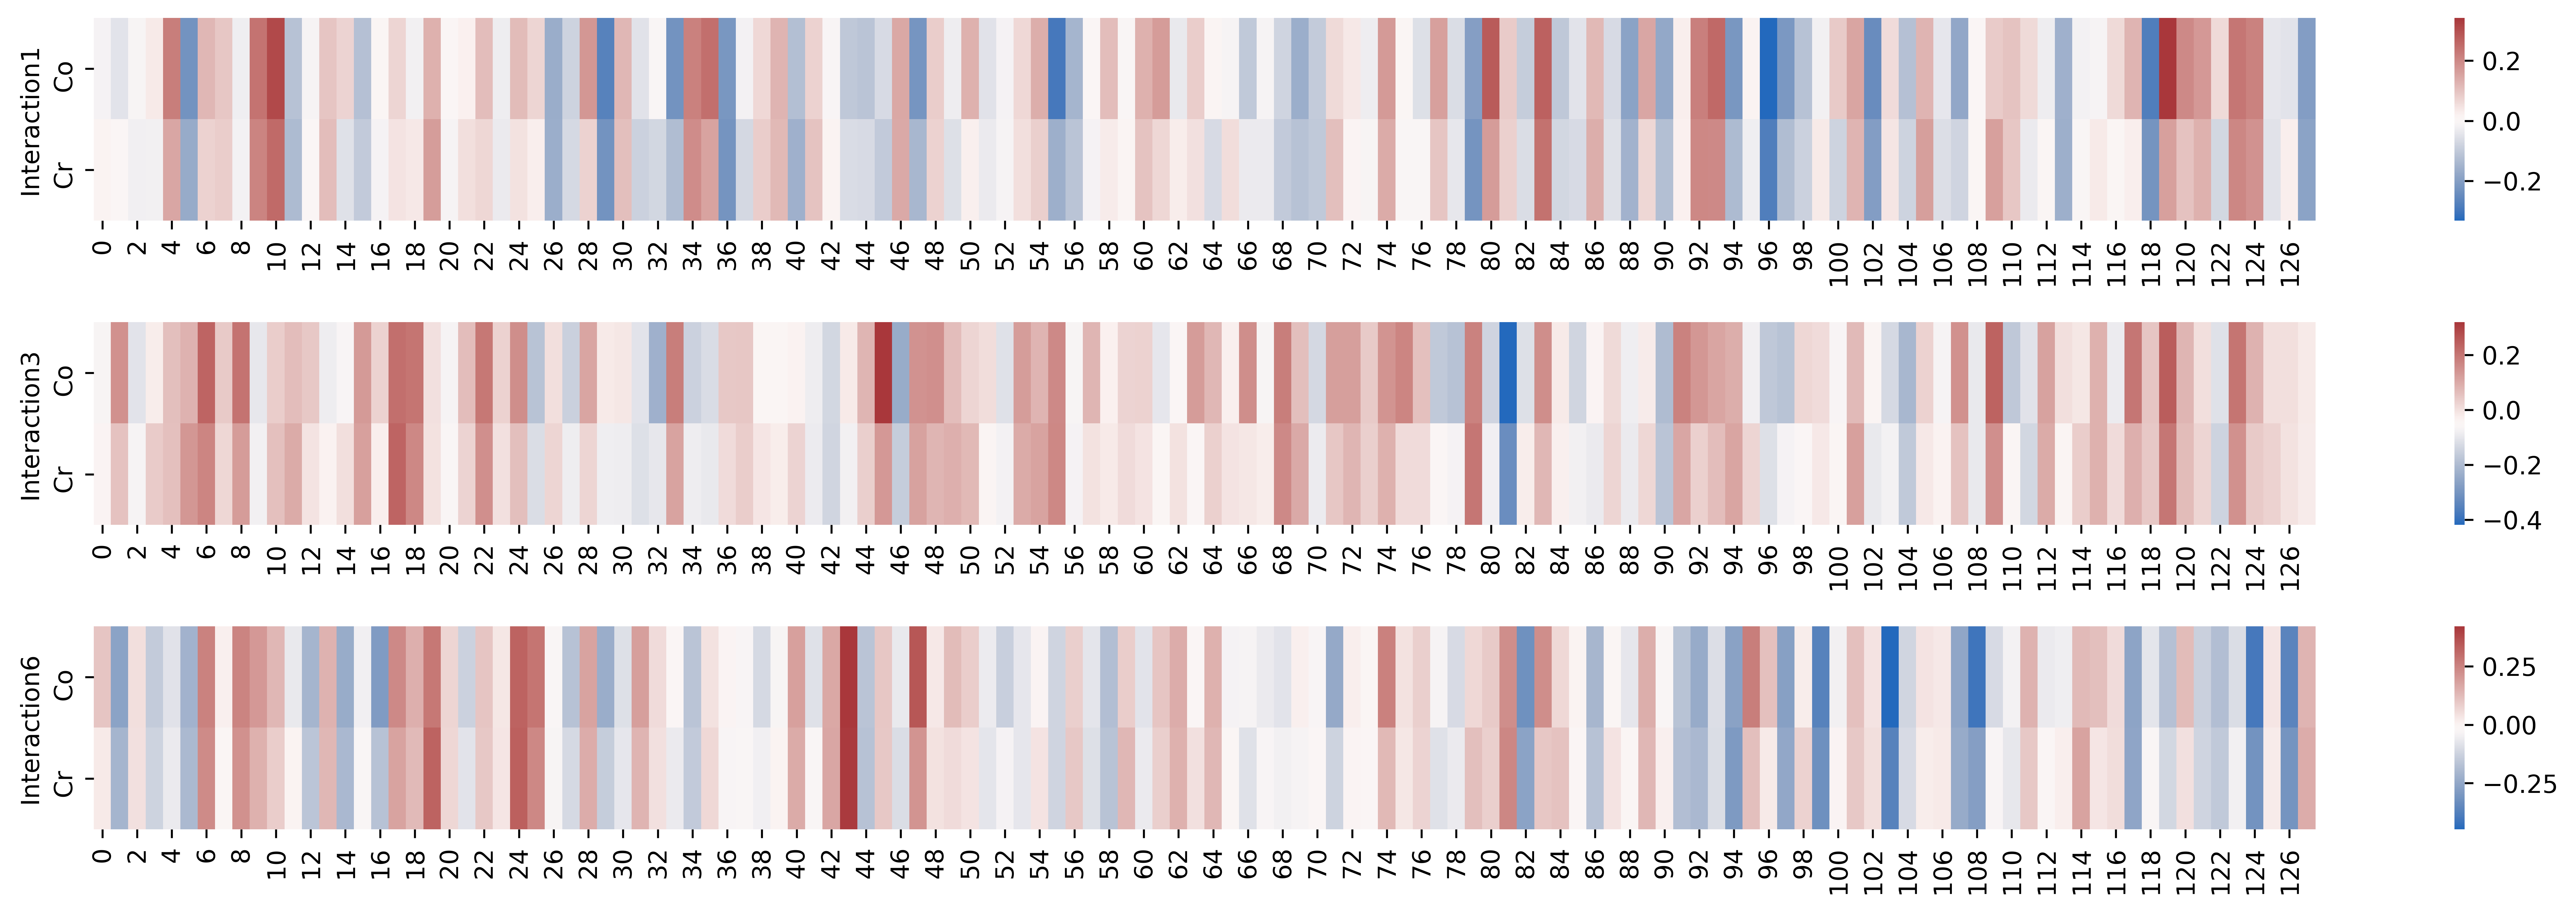

In [58]:
def plot_act(activation):
    feature1 = activation['interactions1']
    feature3 = activation['interactions3']
    feature6 = activation['interactions6']
    # fig = plt.figure(figsize=(20, 8),dpi=300)
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(20,6 ), dpi=600)

    ax1 = plt.subplot(3,1,1)
    ax = sns.heatmap(feature1.numpy(), cmap='vlag', yticklabels=y_axis_labels, ax=ax1)
    ax1.set_ylabel('Interaction1')

    ax2 = plt.subplot(3,1,2)
    ax = sns.heatmap(feature3.numpy(), cmap='vlag', yticklabels=y_axis_labels, ax=ax2)
    ax2.set_ylabel('Interaction3')

    ax3 = plt.subplot(3,1,3)
    ax = sns.heatmap(feature6.numpy(), cmap='vlag', yticklabels=y_axis_labels, ax=ax3)
    ax3.set_ylabel('Interaction6')

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plot_act(activation2)
plt.savefig(os.path.join(fig_path,'features_co3cr_fcc.jpg'))

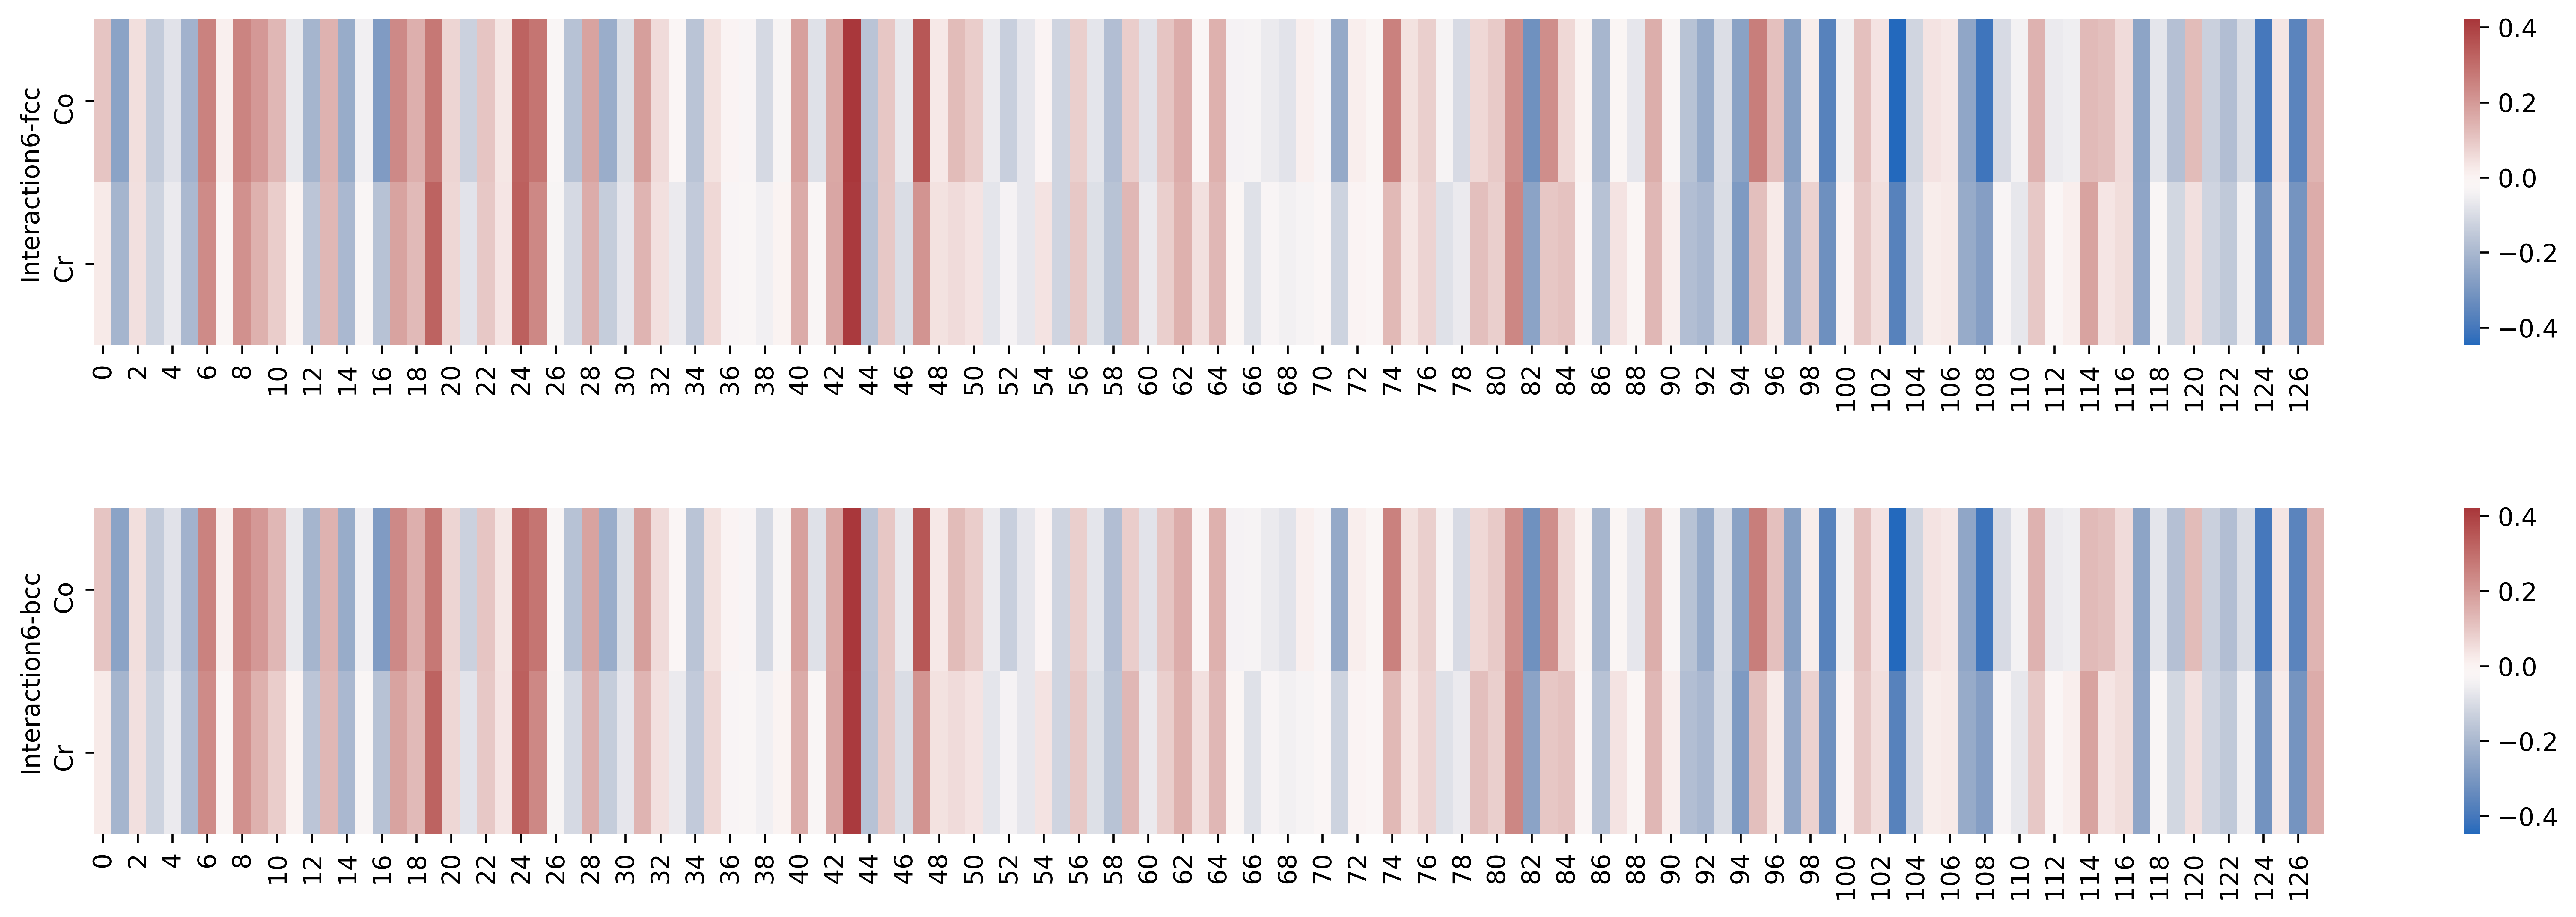

In [61]:
def plot_act(feature1, feature2):
    # fig = plt.figure(figsize=(20, 8),dpi=300)
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20,6 ), dpi=600)

    ax1 = plt.subplot(2,1,1)
    ax = sns.heatmap(feature1.numpy(), cmap='vlag', yticklabels=y_axis_labels, ax=ax1)
    ax1.set_ylabel('Interaction6-fcc')

    ax2 = plt.subplot(2,1,2)
    ax = sns.heatmap(feature2.numpy(), cmap='vlag', yticklabels=y_axis_labels, ax=ax2)
    ax2.set_ylabel('Interaction6-bcc')


    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plot_act(activation2['interactions6'], activation['interactions6'])
plt.savefig(os.path.join(fig_path,'features_co3cr_comp.jpg'))

In [62]:
# activation

In [70]:
model_state = torch.load('./saved_models/ms_type0_300.pt', map_location=torch.device('cpu'))
model.load_state_dict(model_state)
def get_feat(data2):
    activation_test = {}
    def get_activation(name):
        def hook(model, input, output):
    #         print(output.detach().size())
            activation_test[name] = output.detach()
        return hook
    model.interactions[5].lin.register_forward_hook(get_activation('interactions6'))
    output = model(data2.atomic_numbers.long(), data2.pos)
    return activation_test
activation= get_feat(data)
activation2 = get_feat(data2)
def plot_act(feature1, feature2):
    # fig = plt.figure(figsize=(20, 8),dpi=300)
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20,6 ), dpi=600)

    ax1 = plt.subplot(2,1,1)
    ax = sns.heatmap(feature1.numpy(), cmap='vlag', yticklabels=y_axis_labels, ax=ax1)
    ax1.set_ylabel('Interaction6-fcc')

    ax2 = plt.subplot(2,1,2)
    ax = sns.heatmap(feature2.numpy(), cmap='vlag', yticklabels=y_axis_labels, ax=ax2)
    ax2.set_ylabel('Interaction6-bcc')


    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

# plot_act(activation2['interactions6'], activation['interactions6'])
# plt.savefig(os.path.join(fig_path,'features_co3cr_comp.jpg'))

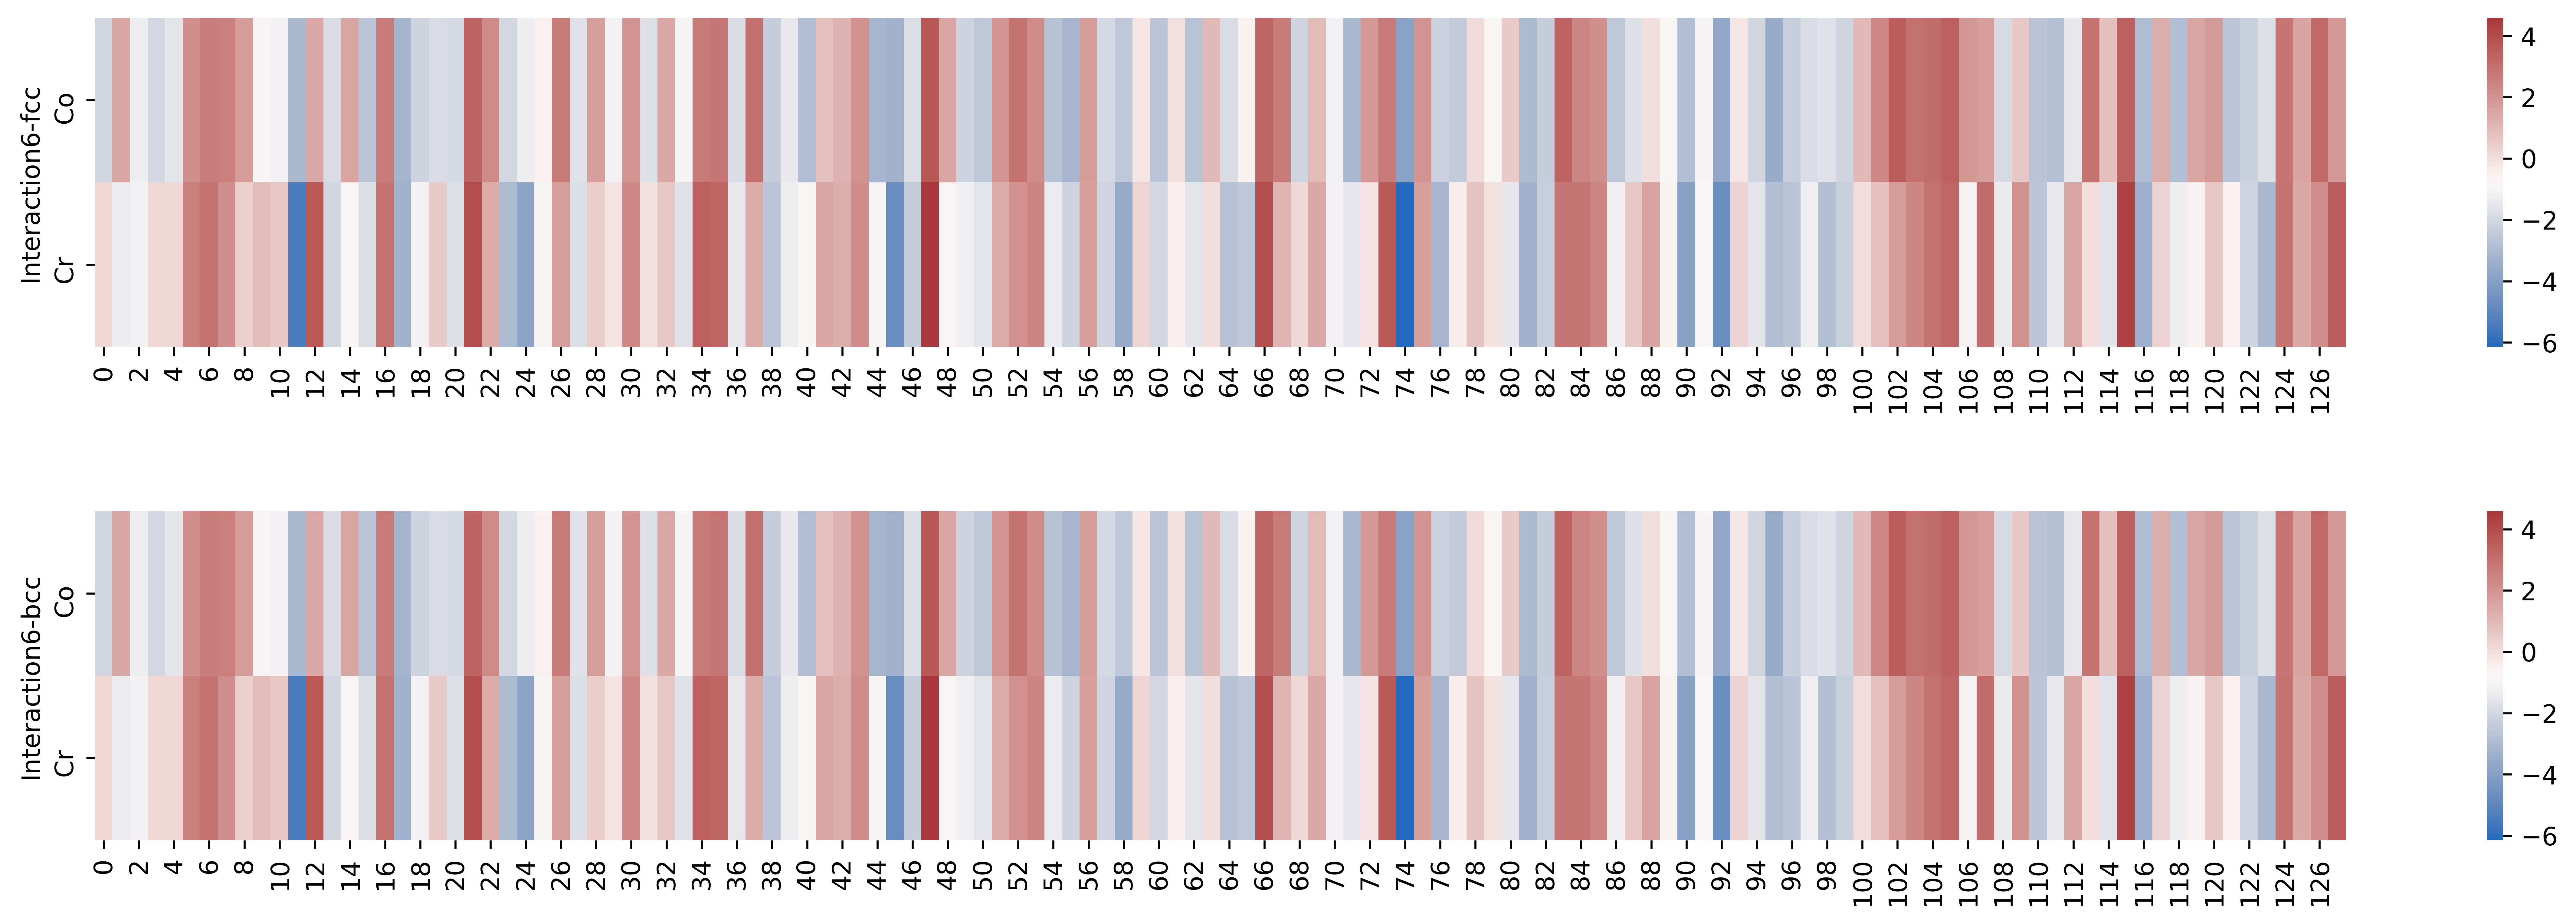

In [71]:
plot_act(activation2['interactions6'], activation['interactions6'])
plt.savefig(os.path.join(fig_path,'features_co3cr_comp.jpg'))

In [9]:
# We try to differentiate the bcc and fcc structures from the features vector.
import pandas as pd
import os
from utils.registry import registry, setup_imports
import torch
from datasets.preprocessing import PoscarToGraph
def convert_data(filename):
    """
    the file name of the poscars
    args:
        filename: str. './HEA_Data/Binary_POSCAR_Files/POSCAR_Co3Cr_sqsfcc'
    """
    pg = PoscarToGraph(radius=6, max_neigh=200)
    data = pg.to_graph(filename)
    return data

def load_data(data_name):
    """
    load the POSCARS and Symmetry of the data(BCC(-1)/FCC(+1)). 
    
    args:
        data_name: str. the dataname like './HEA_Data/Out_labels/Database.xlsx'
        Here, we use the preprocessed  'xlsx' file with one sheet, and a column named structures
    """
    poscar_dir = './HEA_Data/POSCARS'
    wb = pd.read_excel(io=data_name, sheet_name=0, engine='openpyxl')
    poscars = []
    symmetries = []
    for struc in wb.structures:
        poscar = os.path.join(poscar_dir, struc)
        if struc.split('_')[-1]=='sqsfcc':
            symmetry=1
        elif struc.split('_')[-1]=='sqsbcc':
            symmetry = -1
        else:
            raise ValueError("Can not find the symmetry from the name!")
        poscars.append(poscar)
        symmetries.append(symmetry)
    return poscars, symmetries
# out = load_data()  # test the function.

def load_model(model_name):
    """
    load the trained ML models given the model_name
    
    args:
        model_name: str. the name of the trained model.
        For example: './saved_models/ms_type0_300.pt'
    """
    # load the ML model.
    setup_imports()
    model = registry.get_model('heanet'
                               )(hidden_channels=128,
                                 num_filters=64,
                                 num_interactions=3,
                                 num_gaussians=50,
                                 cutoff=10,
                                 readout='add',
                                 dipole=False, mean=None, std=None,
                                 atomref=None,num_tasks=3,
                                tower_h1=128,
                                tower_h2=64)
    # load parameters of trained model
    model_state = torch.load(model_name, map_location=torch.device('cpu'))
    model.load_state_dict(model_state)
    return model

def get_features(model, data):
    """
    Use the trained ML model to predict the features.
    
    args:
        model: Model instance. The trained model with loaded parameters.
        data: The torch_geometric.data.Data object. 
    
    returns:
        a dictionary containing keys and values of featue vectors (torch.Tensor).
        It should be noted that the feature vectors' shape is T*hidden_layers, 
        where T is the number of elemental species. For example, the 'POSCAR_Co3Cr_sqsfcc'
        have a feature vector of 2*128.
    """''
    activation = {}
    def get_activation(name):
        """
        save the output of the model into the dict of 'activation' when call the prediction.
        """
        def hook(model, input, output):
    #         print(output.detach().size())
            activation[name] = output.detach()
        return hook
    model.interactions[0].lin.register_forward_hook(get_activation('interactions1'))
    model.interactions[2].lin.register_forward_hook(get_activation('interactions3'))
#     model.interactions[5].lin.register_forward_hook(get_activation('interactions6'))
    output = model(data.atomic_numbers.long(), data.pos)
    return activation   
# These are the necessary functions for plotting features

In [11]:
from sklearn.manifold import TSNE
import numpy as np


def predict_features():
    """
    Use the trained ML model to predict the features, and use the tsne to reduce the 
    dimensionality.
    
    returns:
        
    """
    # use the 
    model_name = './saved_models_mtl_HEA/mtl_3_etot_emix_ef_HEA_500_b1_best.pt'
    data_name = './HEA_Data/Out_labels/Database.xlsx'
    poscars, symmetries = load_data(data_name)
    model = load_model(model_name)
    X=[]
    for poscar in poscars:
        data = convert_data(poscar)
        activation = get_features(model, data)
#         features = activation['interactions6'].numpy()
        features = features.reshape(-1)
        X.append(features)
#     X = np.concatenate(X, axis=1)
    return X
X = predict_features()

UnboundLocalError: local variable 'features' referenced before assignment

In [89]:
# test = np.vstack(X)
print(X[24].shape)
# model_name = './saved_models/ms_type0_300.pt'
# data_name = './HEA_Data/Out_labels/Database.xlsx'
# poscars, symmetries = load_data(data_name)
# print(poscars[24])
# xx=np.delete(X, [84,85])
# test = np.vstack(xx)

(256,)


In [18]:
model_name = './saved_models/ms_type0_300.pt'
data_name = './HEA_Data/Out_labels/Database.xlsx'
poscars, symmetries = load_data(data_name)
model = load_model(model_name)
activation = {}
def get_activation(name):
    """
    save the output of the model into the dict of 'activation'
    """
    def hook(model, input, output):
#         print(output.detach().size())
        activation[name] = output.detach()
    return hook


In [50]:
activation
model.interactions[0].lin.register_forward_hook(get_activation('interactions1'))
output = model(data2.atomic_numbers.long(), data2.pos)
activation['interactions1'].numpy().reshape(-1).shape

(256,)

In [8]:
model.interactions[0].lin.register_forward_hook(get_activation('interactions1'))
model.interactions[2].lin.register_forward_hook(get_activation('interactions3'))
model.interactions[5].lin.register_forward_hook(get_activation('interactions6'))
output = model(data2.atomic_numbers.long(), data2.pos)

0                     NiFe3_sqsfcc
1                      NiFe_sqsfcc
2                     Ni3Fe_sqsfcc
3                     NiCo3_sqsfcc
4                      NiCo_sqsfcc
                  ...             
359    Fe24Ni24Co24Cr24Pd64_sqsbcc
360    Fe64Ni24Co24Cr24Pd24_sqsbcc
361    Fe24Ni64Co24Cr24Pd24_sqsbcc
362    Fe24Ni24Co64Cr24Pd24_sqsbcc
363    Fe24Ni24Co24Cr64Pd24_sqsbcc
Name: structures, Length: 364, dtype: object

In [34]:
import numpy as np
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X.shape

(4, 3)

In [99]:
# Check the accuracy of the model
from datasets.Mp_dataset import MpDataset
from sklearn.model_selection import train_test_split
from torch_geometric.data import DataLoader

task = 'g'
batch_size=64
def load_mp_data():
    dataset = MpDataset(file_name='./mp.2018.6.1.json', task=task)
    splits = train_test_split(range(len(dataset)), test_size=0.2, shuffle=False)
    if task=='ef' or task=='eg':
        splits = tuple((range(60000), range(60000, len(dataset)) ))
    train_set,test_set = dataset.split(splits)
    train_loader = DataLoader(dataset=train_set, batch_size=batch_size)
    test_loader = DataLoader(dataset=test_set, batch_size=batch_size)
    return train_loader, test_loader
def transform(trans, y, forward=True):
    """
    transform the target y.
    :param
    trans: str. only support scaling and log10.
    y: array.
    :return: transformed array
    """
    if forward==True:
        if trans=='log':
            y = torch.log10(y)
        elif trans=='scaling':
            y=scaling * y
        else:
            y= y
    else: # forward=False
        if trans=='log':
            y = torch.pow(torch.tensor(10), y)
        elif trans=='scaling':
            y=  y/scaling
        else:
            y= y
    return y
# train_loader, test_loader = load_data(split_type=args.split_type)
train_loader, test_loader = load_mp_data()


In [103]:
device = torch.device(device='cuda' if torch.cuda.is_available() else 'cpu')
def test():
    # model_state = torch.load(os.path.join('./saved_models/', args.saved_model))
    # model_name = './saved_models/k_mp_log_10.pt'
    model_name = './saved_models/g_mp_log_200.pt'
    # model_name = './saved_models/g_mp_200.pt'
    model = load_model(model_name)
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        # for batch in train_loader:
        for batch in test_loader:
            batch.to(device)
            out = model(batch.atomic_numbers.long(), batch.pos, batch=batch.batch)
            y_log = transform('log', batch.y, forward=True)
            # y_log = batch.y
            y_true.append(y_log)
            # print(out)
            # print(batch.etot)
            out = transform('log', out, forward=True)
            y_pred.append(out)

    y_true = torch.cat(y_true, dim=0).detach().cpu().numpy()
    y_pred = torch.cat(y_pred, dim=0).detach().cpu().numpy()
    return y_true, y_pred
y_true, y_pred = test()

In [105]:
y_true

array([1.845098 , 1.748188 , 1.7558749, ..., 1.4149734, 0.90309  ,
       1.4149734], dtype=float32)

In [109]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
mae_s = mean_absolute_error(y_pred, y_true)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [114]:
for index, item in enumerate(y_pred):
    if np.isnan(item):
        print('yes')
        print(index)

yes
867
yes
1106


In [118]:
y_pred.squeeze()

array([1.8182687, 1.8774862, 2.0645504, ..., 1.2668661, 0.985704 ,
       1.531211 ], dtype=float32)